In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
from google.colab import files
import io

uploaded = files.upload()
load= pd.read_csv(io.BytesIO(uploaded['data.csv']))

Saving data.csv to data (4).csv


In [68]:
load['Date'] = pd.to_datetime(load['Date'])
load.set_index('Date', inplace=True)

In [69]:
load['weekday'] = (load.index.weekday < 5).astype(int)
load['sin_hour'] = np.sin(2*np.pi*load.index.hour.values/24)
load['cos_hour'] = np.cos(2*np.pi*load.index.hour.values/24)

In [70]:
load = load.dropna()
load = load.loc[:, ~load.columns.str.contains('^Unnamed')]

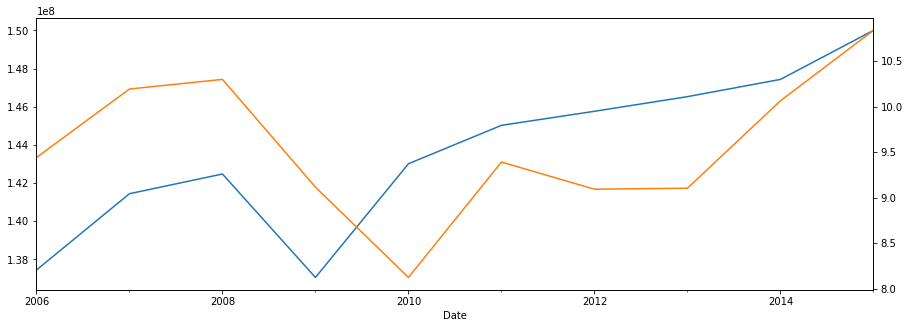

In [71]:
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)


load.resample('1Y').sum()['load'].plot(ax = ax_)
load.resample('1Y').mean()['temp'].plot(ax = ax_, secondary_y = True)

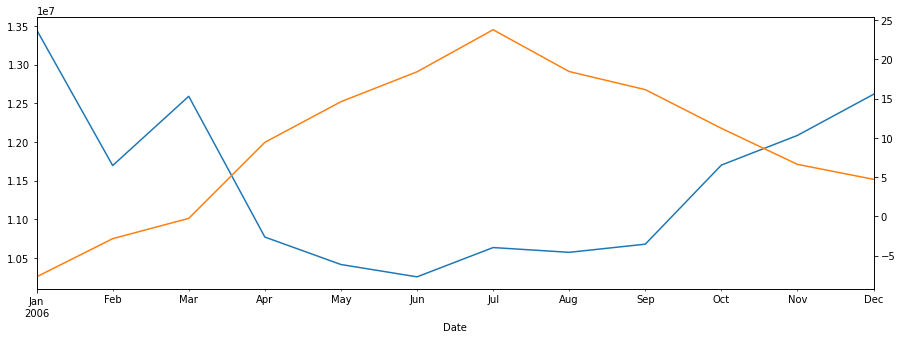

In [72]:
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)


load_year = load.loc['2006']
load_year.resample('1M').sum()['load'].plot(ax = ax_)
load_year.resample('1M').mean()['temp'].plot(ax = ax_, secondary_y = True)

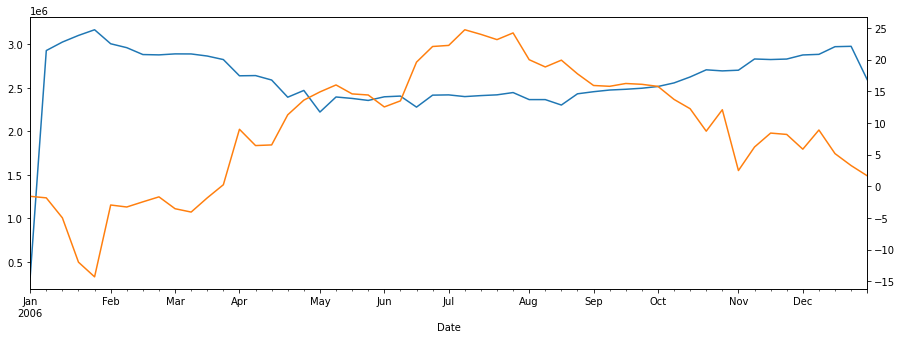

In [73]:
fig = plt.figure(figsize=(15,5))
ax_ = fig.add_subplot(1,1,1)


load_year = load.loc['2006']
load_year.resample('1W').sum()['load'].plot(ax = ax_)
load_year.resample('1W').mean()['temp'].plot(ax = ax_, secondary_y = True)


In [74]:

df_norm = load.copy()

load_min, load_max = load['load'].min(), load['load'].max()
temp_min, temp_max = load['temp'].min(), load['temp'].max()

df_norm['load'] = (load['load'] - load_min) / (load_max - load_min)
df_norm['temp'] = (load['temp'] - temp_min) / (temp_max - temp_min)

df_norm.head()

,load,temp,weekday,sin_hour,cos_hour
Date,,,,,
2006-01-01 00:00:00,0.365654,0.395085,0,0.000000,1.000000
2006-01-01 01:00:00,0.320995,0.395085,0,0.258819,0.965926
2006-01-01 02:00:00,0.282438,0.395085,0,0.500000,0.866025
2006-01-01 03:00:00,0.254208,0.395085,0,0.707107,0.707107
2006-01-01 04:00:00,0.239925,0.395085,0,0.866025,0.500000


# **Sezonowy model SARIMA**

Ponieważ w danych występuje silna sezonowość roczna, trenowany jest sezonowy model SARIMA. Obliczne są średnie miesięczne za pomocą próbkowania

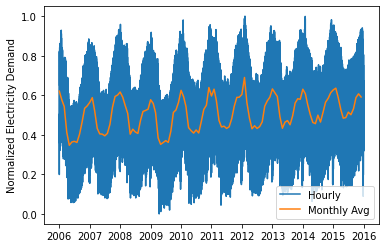

In [75]:

monthly_norm = df_norm['load'].resample('MS').mean().bfill()
plt.plot(df_norm['load'], label='Hourly')
plt.plot(monthly_norm, label='Monthly Avg')
plt.ylabel('Normalized Electricity Demand')
plt.legend();



In [76]:
train = monthly_norm[:'2012']
validate = monthly_norm['2013':'2014']
test = monthly_norm['2015':]

In [77]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# train SARIMA model and get validation set performance
def get_sarima_mae(y_tr, hp, y_te):
    try:
        model = SARIMAX(y_tr, order=(hp[0],hp[1],hp[2]), seasonal_order=(hp[3],hp[4],hp[5],12)).fit()
        y_hat = model.get_forecast(steps=len(y_te)).predicted_mean
        return np.mean(np.abs(y_hat - y_te))
    except:
        return None

# define potential SARIMA hyerparameters
p = d = q = P = D = Q = range(2)
hp_list = list(product(p,d,q,P,D,Q))
grid_search = pd.DataFrame(columns=['p','d','q','P','D','Q','mae'])

# perform grid search
for i, hp in enumerate(hp_list):
    mae = get_sarima_mae(train, hp, validate)
    if mae != None:
        params = {'p':hp[0], 'd':hp[1], 'q':hp[2], 'P':hp[3], 'D':hp[4], 'Q':hp[5], 'mae':mae}
        grid_search = grid_search.append(params, ignore_index=True)

# display best performing hyperparamters
grid_search.sort_values('mae').head(1)

,p,d,q,P,D,Q,mae
52,1.0,1.0,0.0,1.0,0.0,0.0,0.020303


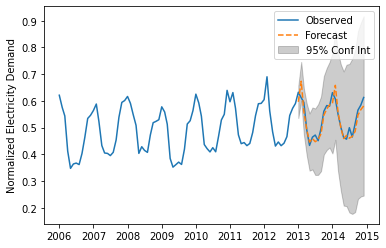

In [78]:
# best hyperparameters from grid search
best_monthly_order = (1,1,0)
best_monthly_seas_order = (1,0,0,12)

# fit SARIMA model
model_m = SARIMAX(train, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()

# get forecast and confidence interval for forecast
forecast = model_m.get_forecast(steps=len(validate))
pred = pd.Series(forecast.predicted_mean, index=validate.index)
ci = forecast.conf_int(alpha=0.05)

# plotting
plt.plot(monthly_norm[:'2014'], label='Observed')
plt.plot(pred, label='Forecast', ls='--')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1],
                 color='k', alpha=0.2, label='95% Conf Int')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

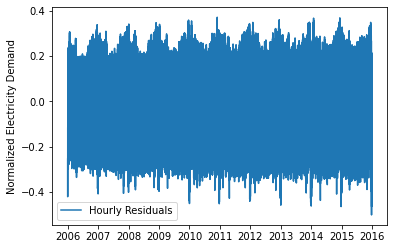

In [79]:
hourly_res_norm = df_norm.copy()
hourly_res_norm['load'] = df_norm['load'].groupby(pd.Grouper(freq='M')).transform(lambda x: x - x.mean())
plt.plot(hourly_res_norm['load'], label='Hourly Residuals')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

In [80]:

train = hourly_res_norm[:'2012']
validate = hourly_res_norm['2013':'2014']
test = hourly_res_norm['2015':]

exog_tr = train.iloc[:,1:].values
ar_tr = train['load'].shift().bfill().values[:,None]
X_tr = np.hstack([ar_tr, exog_tr])
y_tr = train['load'].values

exog_val = validate.iloc[:,1:].values
y_val = validate['load'].values

exog_te = test.iloc[:,1:].values

yp_full = hourly_res_norm.loc[:'2014','load']
yp_val = hourly_res_norm.loc['2013':'2014','load']
yp_te = hourly_res_norm.loc['2015':,'load']
y_init_val = np.hstack([y_tr[-1], validate.iloc[167::168,0].values])
y_init_te = np.hstack([y_val[-1], test.iloc[167::168,0].values])

In [81]:
def compute_mae(y, yhat):
    """given predicted and observed values, computes mean absolute error"""
    return np.mean(np.abs(yhat - y))

def forecast(model, exog, y_init):
    """given a trained model, exogenous features, and initial AR term, makes forecasting predictions"""
    yhat = []
    Xi_te = np.hstack([y_init, exog[0]])[None,:]
    for i in range(len(exog)-1):
        yhat_i = model.predict(Xi_te)[0]
        yhat.append(yhat_i)
        Xi_te = np.hstack([yhat_i, exog[i+1]])[None,:]
    yhat.append(model.predict(Xi_te)[0])
    return np.array(yhat)

def weekly_forecast(model, exog, y_init):
    """given a trained model exogenous features, and initial AR term, makes a series of 1-week-out forecasts"""
    yhat = []
    for i, yi in enumerate(y_init):
        exog_i = exog[24 * 7*i:24 * 7 *(i+1),:]
        if exog_i.shape[0] < 1:
            break
        yhat.append(forecast(model, exog_i, yi))
    return np.hstack(yhat)
    
def plot_full(y, yhat, yhat_idx):
    """plots observed and forecasted values for the full date range"""
    pred = pd.Series(yhat, index=yhat_idx)
    plt.figure()
    plt.plot(y, label='Observed')
    plt.plot(pred, label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    
def plot_week(y, yhat, yhat_idx):
    """plots observed and forecasted values for one week span"""
    pred = pd.Series(yhat, index=yhat_idx)
    fig = plt.figure();
    plt.plot(y['2014-12-01':'2014-12-07'], label='Observed')
    plt.plot(pred['2014-12-01':'2014-12-07'], label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    fig.autofmt_xdate()

**Regresja liniowa**

MAE: 0.07690032041584295


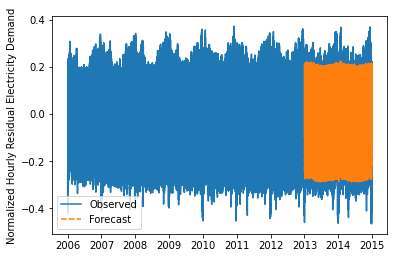

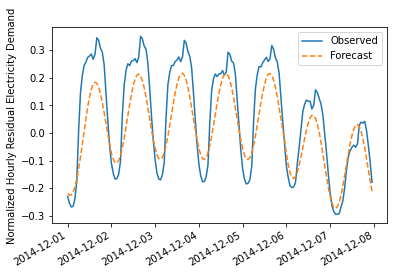

In [83]:
from sklearn.linear_model import LinearRegression

# train model and get predictions
mod_lr = LinearRegression()
mod_lr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_lr, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

**MLPRegressor** z tunowanymi hiperparametrami przy użyciu grid_search

In [84]:
from sklearn.neural_network import MLPRegressor

# train MLP model, and get validation set performance
def get_mlp_mae(hl, a, lr, mi):
    mod = MLPRegressor(hidden_layer_sizes=hl, alpha=a, learning_rate_init=lr, max_iter=mi)
    mod.fit(X_tr, y_tr)
    pred_val = weekly_forecast(mod, exog_val, y_init_val)
    return compute_mae(y_val, pred_val)

# define potential sets of hyperparameters
hidden_layer_sizes = [(100,),(500,),(100,100,)]
alpha = [0.0001, 0.001]
learning_rate = [0.001, 0.01]
max_iter = [1000, 10000]
grid_search = pd.DataFrame(columns=['hl','a','lr','mi','mae'])

# perform grid search
for hl in hidden_layer_sizes:    
    for a in alpha:        
        for lr in learning_rate:
            for mi in max_iter:
                mae = get_mlp_mae(hl, a, lr, mi)
                params = {'hl':hl, 'a':a, 'lr':lr, 'mi':mi, 'mae':mae} 
                grid_search = grid_search.append(params, ignore_index=True)

# display best hyperparameters based on grid search
grid_search.sort_values('mae').head(1)

,hl,a,lr,mi,mae
16,"(100, 100)",0.0001,0.001,1000,0.041517


MAE: 0.0430272380482537


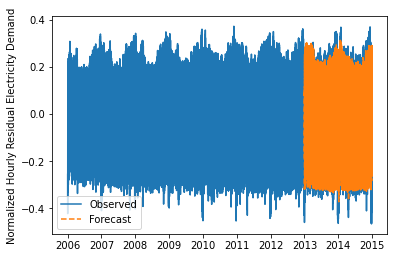

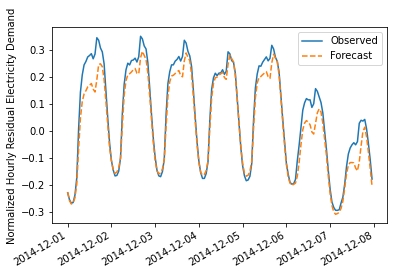

In [85]:
# best hyperparamters
hl, a, lr, mi  = (100, 100), 0.0001, 0.001, 1000

# train model and get predictions
mod_mlp = MLPRegressor(hidden_layer_sizes=hl, alpha=a, learning_rate_init=lr, max_iter=mi)
mod_mlp.fit(X_tr, y_tr)
pred = weekly_forecast(mod_mlp, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

In [86]:
# monthly average forecasts
train_m = monthly_norm[:'2014']
test_m = monthly_norm['2015':]
model_m = SARIMAX(train_m, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()
forecast_m = model_m.get_forecast(steps=len(test_m))
pred_m_norm = pd.Series(forecast_m.predicted_mean, index=test_m.index)

In [87]:
pred_lr = weekly_forecast(mod_lr, exog_te, y_init_te)
pred_mlp = weekly_forecast(mod_mlp, exog_te, y_init_te)

In [88]:
m_norm_df = pd.DataFrame({'m_norm':pred_m_norm, 'month':pred_m_norm.index.month, 'year':pred_m_norm.index.year})

In [89]:
mlp_norm_df = pd.DataFrame({'h_norm':pred_mlp, 'month':test.index.month, 'year':test.index.year})
pred_mlp_norm_df = mlp_norm_df.merge(m_norm_df, on=['month','year'])
pred_mlp_norm = pd.Series((pred_mlp_norm_df['m_norm'] + pred_mlp_norm_df['h_norm']).values, index=test.index)
pred_mlp = pred_mlp_norm * (load_max - load_min) + load_min

In [90]:
# linear regression: combine monthly/hourly forecasts, unnormalize to original scale
pred_lr = weekly_forecast(mod_lr, exog_te, y_init_te)
lr_norm_df = pd.DataFrame({'h_norm':pred_lr, 'month':test.index.month, 'year':test.index.year})
pred_lr_norm_df = lr_norm_df.merge(m_norm_df, on=['month','year'])
pred_lr_norm = pd.Series((pred_lr_norm_df['m_norm'] + pred_lr_norm_df['h_norm']).values, index=test.index)
pred_lr = pred_lr_norm * (load_max - load_min) + load_min

In [91]:
def compute_mape(y, yhat):
    pct_err = ((yhat - y) / y).dropna()
    return np.mean(np.abs(pct_err)) 

print("lin reg MAPE:", compute_mape(load['load'], pred_lr))
print("MLP reg MAPE:", compute_mape(load['load'], pred_mlp))

lin reg MAPE: 0.06923494534399686
MLP reg MAPE: 0.0374777823371053


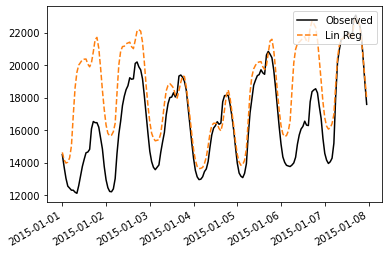

In [92]:
fig, ax = plt.subplots()

ax.plot(load.loc['2015-01-01':'2015-01-07','load'], label='Observed', c='k')
ax.plot(pred_mlp['2015-01-01':'2015-01-07'], label='Lin Reg', ls='--', c='C1')
ax.legend(loc=1);

fig.autofmt_xdate()


**Finalny wynik przy użyciu modelu mlp**

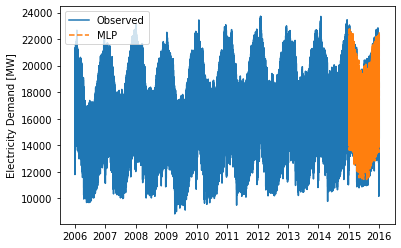

In [93]:
fig = plt.figure()
plt.plot(load.loc[:,'load'], label='Observed')
plt.plot(pred_mlp, label='MLP', ls='--')
plt.ylabel('Electricity Demand [MW]')
plt.legend(loc='upper left');